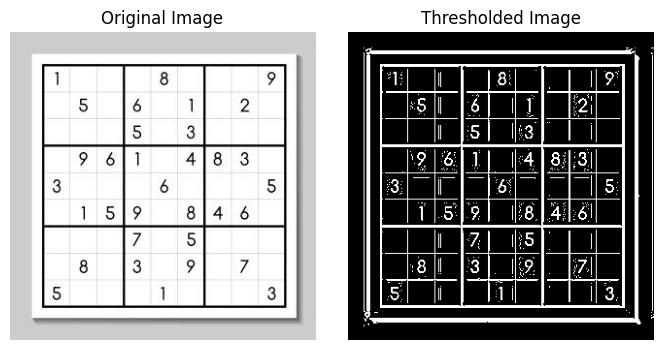

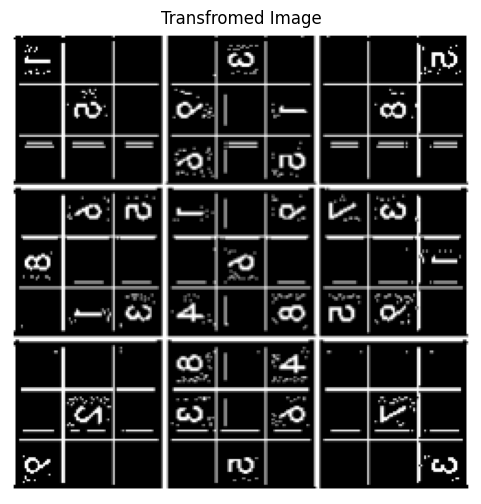

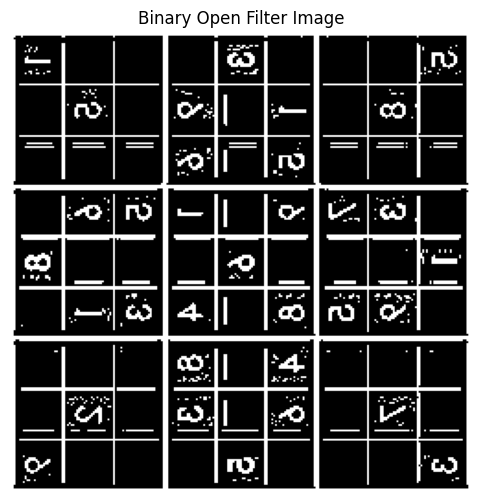

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [34]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

# Configure pytesseract path to the location where tesseract.exe is installed
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'  # Update the path based on your installation


def preprocess_image(image_path):
    """Load an image, convert to grayscale, and apply adaptive thresholding."""
    image = cv2.imread(image_path)
    # gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    # processed_image = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
    processed_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    processed_image = cv2.bitwise_not(processed_image)
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 1, 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')

    return processed_image

def extract_sudoku_grid(image):
    """Extract Sudoku grid from the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]
    perimeter = cv2.arcLength(largest_contour, True)
    roi = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)
    return roi

def get_perspective_transform(image, corners):
    """Apply perspective transform to the grid."""
    corners = sorted(np.concatenate(corners).tolist())
    top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[-1], corners[2]
    side = max([
        np.linalg.norm(np.subtract(top_left, top_right)),
        np.linalg.norm(np.subtract(top_right, bottom_right)),
        np.linalg.norm(np.subtract(bottom_right, bottom_left)),
        np.linalg.norm(np.subtract(bottom_left, top_left))
    ])
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    transformed_image = cv2.warpPerspective(image, m, (int(side), int(side)))
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(transformed_image, cmap='gray')
    plt.title('Transfromed Image')
    plt.axis('off')
    plt.show()
    return cv2.warpPerspective(image, m, (int(side), int(side)))

def extract_digits(transformed_image):
    """Extract digits from each cell of the Sudoku grid."""
    grid_size = transformed_image.shape[0] // 9
    grid = []
    for y in range(9):
        row = []
        for x in range(9):
            x1 = x * grid_size
            y1 = y * grid_size
            x2 = x1 + grid_size
            y2 = y1 + grid_size
            cell = transformed_image[y1:y2, x1:x2]
            digit = pytesseract.image_to_string(cell, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
            try:
                row.append(int(digit.strip()))
            except ValueError:
                row.append(0)  # Assuming empty cell if OCR fails to recognize a digit
        grid.append(row)
    return grid

def apply_opening_filter(image):
    # Load the image
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to make it binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Define the kernel size for the morphological operation
    kernel_size = 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the opening filter
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Save or display the output image
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(opened_image, cmap='gray')
    plt.title('Binary Open Filter Image')
    plt.axis('off')
    plt.show()
    # cv2.imwrite('opened_image.jpg', opened_image)
    # cv2.imshow('Original', binary_image)
    # cv2.imshow('Opened', opened_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

def apply_close_filter(image):
    # Load the image
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to make it binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Define the kernel size for the morphological operation
    kernel_size = 1
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the opening filter
    close_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Save or display the output image
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(closed_image, cmap='gray')
    plt.title('Binary Closed Filter Image')
    plt.axis('off')
    plt.show()
   
def main(image_path):
    processed_image = preprocess_image(image_path)
    roi = extract_sudoku_grid(processed_image)
    transformed_image = get_perspective_transform(processed_image, roi)
    apply_opening_filter(transformed_image)
    sudoku_grid = extract_digits(transformed_image)
    return sudoku_grid

# Example Usage
sudoku_grid = main('./sudoku_unsolved.jpg')
print(np.array(sudoku_grid))


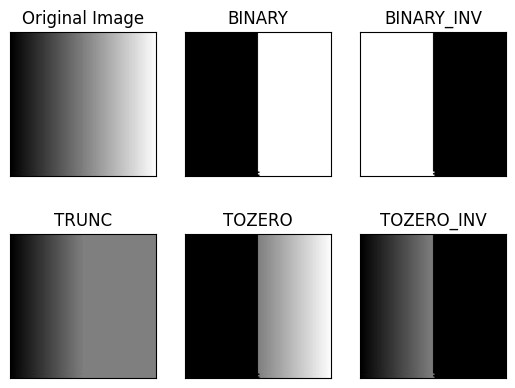

In [28]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
 
img = cv.imread('gradient.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)
 
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
 
for i in range(6):
 plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
 plt.title(titles[i])
 plt.xticks([]),plt.yticks([])
 
plt.show()
